In [1]:
import os
import pandas as pd
import ROOT
from array import array
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
from tableauColors import palette

Welcome to JupyROOT 6.18/00


In [2]:
def modifiedZscore(rdf, col, D=3.5):
    x = rdf.AsNumpy(columns=[col])[col]
    xtilde = np.median(x)
    MAD = np.median(np.abs(x-xtilde))
    return f"abs(0.6745*({col}-({xtilde}))/{MAD}) <= {D}"

In [3]:
# DATA_DIR = '/groups/hep/mojen/repositories/DREAM/Run/final_run/tauolaevts/25000'
DATA_DIR = '/groups/hep/mojen/repositories/DREAM/Analysis'
df = pd.read_csv(os.path.join(DATA_DIR, 'predicted_pi0_mass.csv'))

In [4]:
f = ROOT.TFile('predicted_pi0_mass.root', 'recreate' )
t = ROOT.TTree('predicted_pi0_mass', 'predicted_pi0_mass' )

predicted_pi0_mass = array('d', [0])

t.Branch('predicted_pi0_mass', predicted_pi0_mass, "predicted_pi0_mass/D")

for i in range(df.shape[0]):
    predicted_pi0_mass[0] = df.predicted_pi0_mass.values[i] 
    t.Fill()

f.Write()
f.Close()

In [5]:
d = ROOT.ROOT.RDataFrame("predicted_pi0_mass", "predicted_pi0_mass.root")
d = d.Filter("!std::isnan(predicted_pi0_mass)")
d = d.Filter(modifiedZscore(d, "predicted_pi0_mass"), "modified Z-score")

In [6]:
d.AsNumpy()

{'predicted_pi0_mass': numpy.array([148.83621695, 140.15100357, 141.21349854, ..., 128.96658222,
              142.19572087, 146.95929754])}

 FCN=129.012 FROM MINOS     STATUS=SUCCESSFUL     20 CALLS         160 TOTAL
                     EDM=6.87044e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.06199e+02   2.96226e+00  -7.92018e-03   2.45560e-04
   2  Mean         1.34393e+02   2.05659e-01  -9.63987e-04   7.46067e-04
   3  Sigma        9.88931e+00   1.85272e-01   1.85272e-01   2.79957e-02


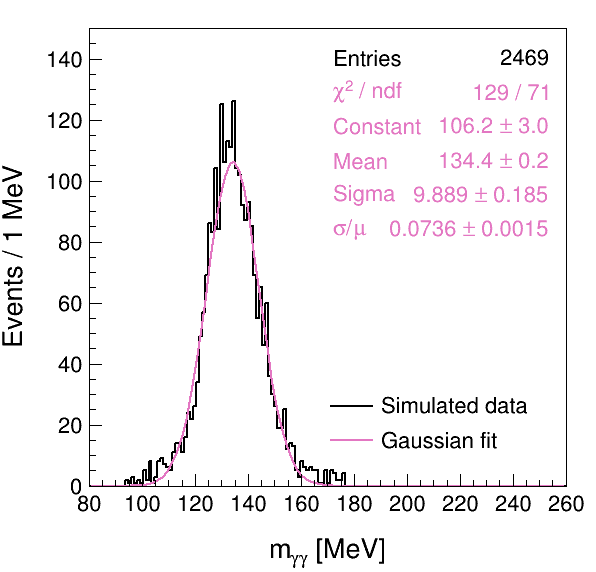

In [30]:
ROOT.gStyle.SetOptStat("emr")
ROOT.gStyle.SetOptFit(1)
c1 = ROOT.TCanvas("c1", "c1", 600, 600)

xlow = 80.
xup = 260.
nbins = 160
binwidth = (xup - xlow)/nbins
model = ("", "", nbins, xlow, xup)
h = d.Histo1D(model, "predicted_pi0_mass")

# h.Fit("gaus", "SEM+R", "", h.GetMean()-1.5*h.GetRMS(), h.GetMean()+1.5*h.GetRMS())
r = h.Fit("gaus", "SEM+")
Res = r.Parameter(2) / r.Parameter(1)
ResErr = Res * (r.ParError(1) / r.Parameter(1) + r.ParError(2) / r.Parameter(2))

h.Draw()

ratio = 1.2
ratio2 = 1.2*ratio
linewidth = 2
linespacing = 0.05

x2ndc = 0.89+0.05
x1ndc = x2ndc-0.4
y2ndc = 0.88+0.05

ROOT.gStyle.SetOptStat("e")

ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.05)
ROOT.gPad.SetBottomMargin(0.15)
ROOT.gPad.SetTopMargin(0.05)

f = h.GetListOfFunctions().FindObject("gaus")
f.SetLineColor(palette['pink'].GetNumber())
f.SetLineWidth(linewidth)

h.SetMaximum(150.)

h.SetLineColor(ROOT.kBlack)
h.SetLineWidth(linewidth)

h.GetXaxis().SetTitle("m_{#gamma#gamma} [MeV]")
h.GetYaxis().SetTitle(f"Events / {binwidth:.1g} MeV")

h.GetXaxis().CenterTitle()
h.GetYaxis().CenterTitle()

h.GetXaxis().SetTitleOffset(ratio2 * h.GetXaxis().GetTitleOffset())
h.GetYaxis().SetTitleOffset(h.GetXaxis().GetTitleOffset()+0.15)

h.GetXaxis().SetTitleSize(ratio2 * h.GetXaxis().GetTitleSize())
h.GetYaxis().SetTitleSize(ratio2 * h.GetYaxis().GetTitleSize())

labelsize = ratio * h.GetXaxis().GetLabelSize()
h.GetXaxis().SetLabelSize(labelsize)
h.GetYaxis().SetLabelSize(labelsize)

h.GetXaxis().SetTickSize(0.7 * ratio * h.GetXaxis().GetTickLength())
h.GetYaxis().SetTickSize(0.7 * ratio * h.GetYaxis().GetTickLength())

labeloffset = (ratio + 1) * h.GetXaxis().GetLabelOffset()
h.GetXaxis().SetLabelOffset(labeloffset)
h.GetYaxis().SetLabelOffset(labeloffset)

c1.Update()

stats1 = h.GetListOfFunctions().FindObject("stats")
h.GetListOfFunctions().Remove(stats1)
h.SetStats(0)
stats1.SetTextColor(palette['pink'].GetNumber())
stats1.GetLineWith('Entries').SetTextColor(ROOT.kBlack)
stats1.AddText(f"#sigma/#mu = {Res:.4f} #pm {ResErr:.4f}")

stats1.SetX2NDC(x2ndc)
stats1.SetX1NDC(x1ndc)
stats1.SetY2NDC(y2ndc)
stats1.SetY1NDC(stats1.GetY2NDC()-6 * ratio * linespacing)
stats1.SetTextSize(h.GetXaxis().GetLabelSize())
stats1.SetBorderSize(0)

stats1.Draw()

# add legend
legend = ROOT.TLegend(stats1.GetX2NDC()-0.4, 0.2, stats1.GetX2NDC(), 0.2+2 * ratio * linespacing)
legend.SetFillColor(0)
legend.SetBorderSize(0)
legend.SetTextSize(labelsize)
legend.AddEntry(h.GetValue(), "Simulated data", "l")
legend.AddEntry(f, "Gaussian fit", "l")
legend.Draw()

c1.Draw()
c1.Print(os.path.join(DATA_DIR, "predicted_pi0_mass.png"))